In [2]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
df1 = pd.read_csv('annotationResults.csv')
df1['weight'] = 100

In [4]:
df2 = pd.read_csv('Batch_3796739_batch_results.csv')
df3 = pd.read_csv('Batch_3796768_batch_results.csv')
df2['weight'] = 80
df3['weight'] = 80
df3.dropna(subset=['Answer.relation'],inplace=True)
df3['Answer.relation'] = df3['Answer.relation'].astype(int)

In [5]:
dfmaster = pd.read_csv('Batch_3797042_batch_results.csv')
dfmaster['weight'] = 100
dfmaster2 = pd.read_csv('Batch_3799572_batch_results.csv')
dfmaster2['weight'] = 100

In [6]:
!ls *.csvs

ls: cannot access '*.csvs': No such file or directory


In [7]:
df = pd.concat([df1,df2,df3,dfmaster,dfmaster2],ignore_index=True)

/home/alex/anaconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [8]:
df.columns

Index(['AcceptTime', 'Answer.entity1_hidden', 'Answer.entity2_hidden',
       'Answer.id', 'Answer.multiple_relations', 'Answer.relation',
       'ApprovalTime', 'Approve', 'AssignmentDurationInSeconds',
       'AssignmentId', 'AssignmentStatus', 'AutoApprovalDelayInSeconds',
       'AutoApprovalTime', 'CreationTime', 'Description', 'Expiration',
       'HITId', 'HITTypeId', 'Input.id', 'Input.sentence', 'Keywords',
       'Last30DaysApprovalRate', 'Last7DaysApprovalRate',
       'LifetimeApprovalRate', 'LifetimeInSeconds', 'MaxAssignments',
       'NumberOfSimilarHITs', 'Reject', 'RejectionTime', 'RequesterAnnotation',
       'RequesterFeedback', 'Reward', 'SubmitTime', 'Title',
       'WorkTimeInSeconds', 'WorkerId', 'weight'],
      dtype='object')

In [9]:
df.loc[58]

AcceptTime                                          Sat Jun 08 12:30:55 PDT 2019
Answer.entity1_hidden                             {"value":"","start":0,"end":0}
Answer.entity2_hidden                             {"value":"","start":0,"end":0}
Answer.id                                                                   2020
Answer.multiple_relations                                                    NaN
Answer.relation                                                                7
ApprovalTime                                        Mon Jun 10 10:46:01 PDT 2019
Approve                                                                      NaN
AssignmentDurationInSeconds                                                 3600
AssignmentId                                      3UJ1CZ6IZJYFPUGEDEL9V2AUXLDS5D
AssignmentStatus                                                        Approved
AutoApprovalDelayInSeconds                                                604800
AutoApprovalTime            

In [10]:
df.groupby('Input.id').size().max()

6

In [11]:
df['time'] = pd.to_datetime(df.SubmitTime) - pd.to_datetime(df.AcceptTime)

/home/alex/anaconda3/envs/main/lib/python3.7/site-packages/dateutil/parser/_parser.py:1204: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [12]:
df['seconds'] = df.time.astype(int)/1000000000

In [13]:
import seaborn as sns
#sns.distplot(x=)

In [14]:
df.seconds.describe()

count    21028.000000
mean        50.568242
std        171.228875
min          3.000000
25%         10.000000
50%         18.000000
75%         35.000000
max       3410.000000
Name: seconds, dtype: float64

In [15]:
###### 500 5
# 700 16.2
# 900 32.4

In [16]:
len(df[df.seconds>15]),len(df)

(11643, 21028)

In [17]:
!pip install sklearn

You are using pip version 18.1, however version 19.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [18]:
from sklearn.utils.extmath import weighted_mode
def compute_mode(group):
    w = group.weight*group.seconds
    m = weighted_mode(group['Answer.relation'],w)[0][0]
    l = len(group[group['Answer.multiple_relations']=='on'])
    return pd.Series({'relation':m,'agreement':len(group[group['Answer.relation']==m])/len(group),'multiple':l})

In [19]:
answers = df.groupby('Input.id').apply(compute_mode)

In [20]:
answers.head()

,relation,agreement,multiple
Input.id,,,
0,1.0,0.6,3.0
1,3.0,1.0,0.0
2,0.0,0.4,0.0
3,0.0,0.6,2.0
4,0.0,0.4,0.0


In [21]:
reliable = answers[(answers.agreement>0.7) | (answers.multiple>=1) ]

In [22]:
len(reliable)

1587

In [23]:
mapp = pd.read_csv('query_relations_noduplicates.csv')

In [24]:
mapp.columns

Index(['id', 'match', 'query_id', 'query', 'corpus', 'corpus_id', 'hit_id',
       'text_id', 'tagged_match', 'url', 'begin', 'end', 'sentence'],
      dtype='object')

In [25]:
len(mapp)

4247

In [26]:
mapp.set_index('id',inplace=True)

In [27]:
reliable['query_id'] = mapp.loc[reliable.index]['query_id']

/home/alex/anaconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [28]:
reliable.groupby('query_id').size()

query_id
0    570
1    143
2    498
3     78
4    275
5     23
dtype: int64

In [29]:
reliable.groupby('relation').size()

relation
0.0    446
1.0    173
2.0     42
3.0    376
4.0    217
5.0     47
6.0     50
7.0    236
dtype: int64

In [30]:
from sklearn.utils.extmath import weighted_mode

In [31]:
weighted_mode([1,1,4,4,4],[10,1,0.2,0.2,0.2])

(array([1.]), array([11.]))

In [32]:
len(reliable[reliable.relation==7])

236

In [33]:
df1['Answer.relation'].unique()

array([7, 0, 4, 3, 1, 2, 6, 5])

In [34]:
df2['Answer.relation'].unique()

array([3, 0, 7, 2, 4, 1, 6])

In [35]:
df3['Answer.relation'].unique()

array([5, 1, 0, 4, 6, 3, 2, 7])

In [36]:
dfmaster['Answer.relation'].unique()

array([0, 4, 7, 3, 5, 1, 2, 6])

In [37]:
len(df3)

8459

In [38]:
out = pd.read_csv('to_annotate.csv',index_col=0)

In [39]:
out.head()

,sentence
id,
0,What do I wear to a fashion event to stand o...
1,The designer who has spent several years in fa...
2,On the invitation it says to dress to impress ...
3,"For a day on campus , try a white and black ja..."
4,Fall 2013 Style Inspiration : What To Wear To ...


In [40]:
reliable.head()

,relation,agreement,multiple,query_id
Input.id,,,,
0,1.0,0.60,3.0,0
1,3.0,1.00,0.0,0
3,0.0,0.60,2.0,0
5,1.0,0.40,1.0,0
6,7.0,0.75,0.0,5


In [41]:
out.iloc[reliable[reliable.relation==7].index]

,sentence
id,
6,"It 's still 40 degrees in some places , after ..."
20,I wanted to be grown-up . ''
27,These customers want their shopping experien...
29,Do you have a special event or celebration c...
31,`` My real anxiety was that I would never wan...
49,Now pass the pie ... What 's the best thing to...
52,If Depp ever does want to give up the day jo...
54,Customer service is also very important to me ...
68,Madonna hand-picked her favourite eight pieces...


In [42]:
without7 = out[~out.index.isin(reliable[reliable.relation==7].index)]

In [43]:
without7.to_csv('to_annotatew7.csv')


In [44]:
!head to_annotatew7.csv

id,sentence
0,"What do I  wear  to a fashion event to stand out , but not look like I 'm trying too Fashion events definitely bring out many attendees ' dramatic side , but you do n't need to channel Anna Dello Russo or Lady Gaga to fit in ."
1,"The designer who has spent several years in fashion , starting off in the intricate art of pattern-making , has just debuted his women's  wear  brand Daniele Bardis ."
2,"On the invitation it says to dress to impress , I dont want to over do it but I do  want  to stand out ."
3,"For a day on campus , try a white and black jacket by Acne along with coated skinny black jeans :  Wear  a pair of Converse sneakers for the day , then slip into sleek stilettos for an evening on the town : And for the super casual , I incorporated a host of pieces , including a $ 40 Varsity jacket from Delia ¡ ¦ s , Markus Lupfer ¡ ¥"
4,Fall 2013 Style Inspiration : What To Wear To A Black Tie Retirement Party You ladies are quite the socialites as your formal attire W

In [45]:
len(without7)

3996

In [46]:
df.columns

Index(['AcceptTime', 'Answer.entity1_hidden', 'Answer.entity2_hidden',
       'Answer.id', 'Answer.multiple_relations', 'Answer.relation',
       'ApprovalTime', 'Approve', 'AssignmentDurationInSeconds',
       'AssignmentId', 'AssignmentStatus', 'AutoApprovalDelayInSeconds',
       'AutoApprovalTime', 'CreationTime', 'Description', 'Expiration',
       'HITId', 'HITTypeId', 'Input.id', 'Input.sentence', 'Keywords',
       'Last30DaysApprovalRate', 'Last7DaysApprovalRate',
       'LifetimeApprovalRate', 'LifetimeInSeconds', 'MaxAssignments',
       'NumberOfSimilarHITs', 'Reject', 'RejectionTime', 'RequesterAnnotation',
       'RequesterFeedback', 'Reward', 'SubmitTime', 'Title',
       'WorkTimeInSeconds', 'WorkerId', 'weight', 'time', 'seconds'],
      dtype='object')

In [47]:
len(df)

21028

In [48]:
(df.groupby('WorkerId').size()>5).sum()

186

In [49]:
tt = df.groupby('WorkerId').size()
tt= tt[tt>5]
len(tt)

186

In [50]:
len(tt.index)

186

In [51]:
df=df[df.WorkerId.isin(tt.index)]

# David Skene

In [52]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

In [53]:
df[['WorkerId','Answer.relation','Answer.id']]

,WorkerId,Answer.relation,Answer.id
0,A2EN7IXP9RG0O2,7,2612
1,A16XYHB1I4PDHL,0,2211
2,A6KOTWP7N7RLU,7,1408
3,A16XYHB1I4PDHL,7,2613
4,A13IM8SYBMVTZL,4,2212
5,A38NFX88VZDMJ3,0,1207
6,A16XYHB1I4PDHL,7,2614
7,A6KOTWP7N7RLU,0,2213
8,A16XYHB1I4PDHL,3,2011
9,A6KOTWP7N7RLU,0,3012


In [54]:
df['WorkerId'] = df['WorkerId'].astype("category")
df['Answer.id'] = df['Answer.id'].astype("category")
df['Answer.relation'] = df['Answer.relation'].astype("category")
df['w'] = df['WorkerId'].cat.codes
df['i'] = df['Answer.id'].cat.codes
df['r'] = df['Answer.relation'].cat.codes

In [55]:
df['w'].map(dict( enumerate(df['WorkerId'].cat.categories)))==df['WorkerId']

0        True
1        True
2        True
3        True
4        True
5        True
6        True
7        True
8        True
9        True
10       True
11       True
12       True
13       True
14       True
15       True
16       True
17       True
18       True
19       True
20       True
21       True
22       True
23       True
24       True
25       True
26       True
27       True
28       True
29       True
         ... 
20998    True
20999    True
21000    True
21001    True
21002    True
21003    True
21004    True
21005    True
21006    True
21007    True
21008    True
21009    True
21010    True
21011    True
21012    True
21013    True
21014    True
21015    True
21016    True
21017    True
21018    True
21019    True
21020    True
21021    True
21022    True
21023    True
21024    True
21025    True
21026    True
21027    True
Length: 20740, dtype: bool

In [56]:
dict( enumerate(df['Answer.relation'].cat.categories))

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}

In [57]:
import pymc3 as pm
from sklearn.metrics import confusion_matrix

In [58]:
df.r.nunique()

8

In [59]:
I = df.i.nunique()               # number of items
J = df.w.nunique()               # number of annotators
K = df.r.nunique()              # number of classes
N = I * J

In [60]:
# class prevalence (flat prior)
alpha = np.ones( K )

# individual annotator confusion matrices - dominant diagonal
beta = np.ones( (K,K) ) + np.diag( np.ones(K) )

In [61]:
from sklearn.utils.extmath import weighted_mode
def compute_mode(group):
    w = 1 #group.weight*group.seconds
    m = weighted_mode(group['Answer.relation'],w)[0][0]
    l = len(group[group['Answer.multiple_relations']=='on'])
    return pd.Series({'relation':int(m),'agreement':len(group[group['Answer.relation']==m])/len(group),'multiple':l})
answers = df.groupby('Input.id').apply(compute_mode)

In [62]:
answers['relation'] = answers.relation.astype(int).astype("category")
dict( enumerate(answers.relation.cat.categories))

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}

In [63]:
answers.head()

,relation,agreement,multiple
Input.id,,,
0,1,0.6,3.0
1,3,1.0,0.0
2,0,0.4,0.0
3,0,0.6,2.0
4,0,0.4,0.0


In [64]:
mapparel = answers['relation'].to_dict()
mapparel

{0: 1,
 1: 3,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 7,
 7: 3,
 8: 4,
 9: 1,
 10: 4,
 11: 0,
 12: 7,
 13: 0,
 14: 0,
 15: 3,
 16: 3,
 17: 0,
 18: 4,
 19: 0,
 20: 7,
 21: 4,
 22: 4,
 23: 3,
 24: 0,
 25: 7,
 26: 3,
 27: 0,
 28: 4,
 29: 7,
 30: 3,
 31: 7,
 32: 4,
 33: 0,
 34: 2,
 35: 5,
 36: 2,
 37: 3,
 38: 0,
 39: 0,
 40: 1,
 41: 3,
 42: 3,
 43: 3,
 44: 0,
 45: 3,
 46: 4,
 47: 0,
 48: 1,
 49: 7,
 50: 4,
 51: 0,
 52: 7,
 53: 7,
 54: 7,
 55: 3,
 56: 1,
 57: 4,
 58: 1,
 59: 7,
 60: 0,
 61: 0,
 62: 0,
 63: 1,
 64: 3,
 65: 0,
 66: 5,
 67: 0,
 68: 0,
 69: 1,
 70: 5,
 71: 0,
 72: 0,
 73: 0,
 74: 3,
 75: 7,
 76: 7,
 77: 0,
 78: 7,
 79: 4,
 80: 0,
 81: 0,
 82: 0,
 83: 1,
 84: 0,
 85: 7,
 86: 0,
 87: 3,
 88: 3,
 89: 0,
 90: 7,
 91: 5,
 92: 4,
 93: 7,
 94: 4,
 95: 1,
 96: 0,
 97: 0,
 98: 0,
 99: 0,
 100: 0,
 101: 2,
 102: 1,
 103: 3,
 104: 0,
 105: 7,
 106: 3,
 107: 1,
 108: 3,
 109: 3,
 110: 7,
 111: 7,
 112: 3,
 113: 3,
 114: 7,
 115: 0,
 116: 2,
 117: 0,
 118: 3,
 119: 4,
 120: 7,
 121: 6,
 122: 7,
 12

In [65]:
np.where(pd.isna(df['Answer.id'].map(mapparel)))

(array([], dtype=int64),)

In [66]:
df['Answer.id']

0        2612
1        2211
2        1408
3        2613
4        2212
5        1207
6        2614
7        2213
8        2011
9        3012
10       1409
11       2615
12       1208
13       2616
14       2012
15       1410
16       1209
17       1411
18       1210
19       2617
20       3013
21       1211
22       2013
23       2214
24       3014
25       2618
26       2014
27       2215
28       3015
29       2619
         ... 
20998    4149
20999    3940
21000    3941
21001    4150
21002    4151
21003    3942
21004    4152
21005    3943
21006    4153
21007    3944
21008    4154
21009    3945
21010    4155
21011    3946
21012    4156
21013    3947
21014    4157
21015    3948
21016    4158
21017    4159
21018    3949
21019    4160
21020    4161
21021    3950
21022    3951
21023    3952
21024    3953
21025    3954
21026    3955
21027    3956
Name: Answer.id, Length: 20740, dtype: category
Categories (4232, int64): [0, 1, 2, 3, ..., 4243, 4244, 4245, 4246]

In [67]:
mappaii=dict(enumerate(df['Answer.id'].cat.categories))

In [68]:
df['majority'] = df['Answer.id'].map(mapparel)
df.head()

,AcceptTime,Answer.entity1_hidden,Answer.entity2_hidden,Answer.id,Answer.multiple_relations,Answer.relation,ApprovalTime,Approve,AssignmentDurationInSeconds,AssignmentId,...,Title,WorkTimeInSeconds,WorkerId,weight,time,seconds,w,i,r,majority
0,Sat Jun 08 11:38:00 PDT 2019,"{""value"":"""",""start"":0,""end"":0}","{""value"":"""",""start"":0,""end"":0}",2612,NaN,7,Mon Jun 10 03:51:40 PDT 2019,NaN,3600,3GDTJDAPVWKVEHMBRFWQVDLF7MQ8MD,...,Classification of a short sentence about fashi...,18,A2EN7IXP9RG0O2,100,00:00:18,18.0,65,2600,7,7
1,Sat Jun 08 15:08:29 PDT 2019,"{""value"":"""",""start"":0,""end"":0}","{""value"":""leopard printed frock"",""start"":116,""...",2211,NaN,0,Mon Jun 10 10:44:56 PDT 2019,NaN,3600,3OUYGIZWR97JHVELORB3J29STTDP0R,...,Classification of a short sentence about fashi...,56,A16XYHB1I4PDHL,100,00:00:56,56.0,8,2200,0,0
2,Sat Jun 08 13:04:06 PDT 2019,"{""value"":"""",""start"":0,""end"":0}","{""value"":"""",""start"":0,""end"":0}",1408,NaN,7,Mon Jun 10 04:00:37 PDT 2019,NaN,3600,3LOZAJ85YFMVMEJQP5PYW3OASQSX2T,...,Classification of a short sentence about fashi...,24,A6KOTWP7N7RLU,100,00:00:24,24.0,140,1400,7,7
3,Sat Jun 08 12:23:14 PDT 2019,"{""value"":"""",""start"":0,""end"":0}","{""value"":"""",""start"":0,""end"":0}",2613,NaN,7,Mon Jun 10 10:43:12 PDT 2019,NaN,3600,33LKR6A5KGTHGCSA1RON2HTZNOM1TT,...,Classification of a short sentence about fashi...,116,A16XYHB1I4PDHL,100,00:01:56,116.0,8,2601,7,1
4,Sat Jun 08 17:26:39 PDT 2019,"{""value"":""Goulandris"",""start"":18,""end"":29}","{""value"":""her designs to be seen as `` the LBD...",2212,NaN,4,Mon Jun 10 10:41:12 PDT 2019,NaN,3600,3HVVDCPGTG1E6I3DDGVWG449VAOTYF,...,Classification of a short sentence about fashi...,176,A13IM8SYBMVTZL,100,00:02:56,176.0,4,2201,4,4


In [69]:
answers.tail()

,relation,agreement,multiple
Input.id,,,
4242,0,0.6,1.0
4243,4,0.4,0.0
4244,7,0.4,0.0
4245,2,0.4,0.0
4246,2,0.4,0.0


In [70]:
testval = []
for i in range(I):
    testval.append(answers.loc[mappaii[i]].relation)

In [71]:
df.columns

Index(['AcceptTime', 'Answer.entity1_hidden', 'Answer.entity2_hidden',
       'Answer.id', 'Answer.multiple_relations', 'Answer.relation',
       'ApprovalTime', 'Approve', 'AssignmentDurationInSeconds',
       'AssignmentId', 'AssignmentStatus', 'AutoApprovalDelayInSeconds',
       'AutoApprovalTime', 'CreationTime', 'Description', 'Expiration',
       'HITId', 'HITTypeId', 'Input.id', 'Input.sentence', 'Keywords',
       'Last30DaysApprovalRate', 'Last7DaysApprovalRate',
       'LifetimeApprovalRate', 'LifetimeInSeconds', 'MaxAssignments',
       'NumberOfSimilarHITs', 'Reject', 'RejectionTime', 'RequesterAnnotation',
       'RequesterFeedback', 'Reward', 'SubmitTime', 'Title',
       'WorkTimeInSeconds', 'WorkerId', 'weight', 'time', 'seconds', 'w', 'i',
       'r', 'majority'],
      dtype='object')

In [72]:
df.i

0        2600
1        2200
2        1400
3        2601
4        2201
5        1200
6        2602
7        2202
8        2000
9        3000
10       1401
11       2603
12       1201
13       2604
14       2001
15       1402
16       1202
17       1403
18       1203
19       2605
20       3001
21       1204
22       2002
23       2203
24       3002
25       2606
26       2003
27       2204
28       3003
29       2607
         ... 
20998    4134
20999    3926
21000    3927
21001    4135
21002    4136
21003    3928
21004    4137
21005    3929
21006    4138
21007    3930
21008    4139
21009    3931
21010    4140
21011    3932
21012    4141
21013    3933
21014    4142
21015    3934
21016    4143
21017    4144
21018    3935
21019    4145
21020    4146
21021    3936
21022    3937
21023    3938
21024    3939
21025    3940
21026    3941
21027    3942
Name: i, Length: 20740, dtype: int16

In [73]:
df.i.tail()

21023    3938
21024    3939
21025    3940
21026    3941
21027    3942
Name: i, dtype: int16

In [74]:
df.w.tail()

21023     87
21024    148
21025    158
21026     87
21027     87
Name: w, dtype: int16

In [75]:
np.array(testval).max()

7

In [76]:
import theano.tensor as tt
model = pm.Model()

with model:
    goodness = pm.Gamma('goodness', mu=1,sd=1,shape=J)
    beta = []
    for i in range(J):
        beta.append(np.ones( (K,K) ) + goodness[i]* np.diag( np.ones(K) ))
    beta = tt.as_tensor_variable(beta)
    beta = beta.reshape((J,K,K))
    pi = pm.Dirichlet( 'pi', a=alpha, shape=K )
    #theta = []
    #for i in range(J):
    #    theta.append(pm.Dirichlet( 'theta'+str(i), a=beta[i],shape=(K,K) ))
    #theta = tt.as_tensor_variable(theta)
    #theta = theta.reshape((J,K,K))
    z = pm.Categorical( 'z', p=pi, shape=I, testval=testval )
    y_obs = pm.Categorical( 'y_obs', p=beta[ df.w.values, z[ df.i.values ] ], observed=df.r.values )

/home/alex/anaconda3/envs/main/lib/python3.7/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/alex/anaconda3/envs/main/lib/python3.7/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [79]:
with model:
#    step1 = pm.Metropolis( vars=[pi,theta] )
#    step2 = pm.CategoricalGibbsMetropolis( vars=[z] )
    trace = pm.sample( 2500, progressbar=True,njobs=8 )

/home/alex/anaconda3/envs/main/lib/python3.7/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (8 chains in 8 jobs)
CompoundStep
>NUTS: [pi, goodness]
>CategoricalGibbsMetropolis: [z]
Sampling 8 chains:  14%|█▍        | 3324/24000 [2:12:26<10:52:56,  1.89s/draws]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Sampling 8 chains:  43%|████▎     | 10266/24000 [6:50:00<9:53:25,  2.59s/draws

In [82]:
ls

annotationResults.csv                Dawid_Skene.ipynb
assign_qual-first_step3796768.ipynb  Dawid_Skene-simplified.ipynb
Batch_3796739_batch_results.csv      query_relations_noduplicates.csv
Batch_3796768_batch_results.csv      quick_analysis.ipynb
Batch_3797042_batch_results.csv      to_annotate.csv
Batch_3799572_batch_results.csv      to_annotatew7.csv


In [83]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
z__0,0.793850,0.925663,0.015795,0.000000e+00,1.000000,3830.626760,1.000575
z__1,3.001600,0.147640,0.001827,3.000000e+00,3.000000,NaN,1.000451
z__2,1.584950,2.910770,0.058028,0.000000e+00,7.000000,2048.495250,1.002359
z__3,0.093050,0.582831,0.015312,0.000000e+00,0.000000,1418.561696,1.002886
z__4,0.114900,0.748664,0.015566,0.000000e+00,0.000000,2194.490842,1.001209
z__5,0.014100,0.221362,0.004646,0.000000e+00,0.000000,NaN,1.003522
z__6,6.855650,0.974737,0.027716,7.000000e+00,7.000000,1156.529789,1.002584
z__7,1.218300,1.829247,0.037202,0.000000e+00,4.000000,2388.670942,1.003191
z__8,2.620600,2.650294,0.046514,0.000000e+00,7.000000,3618.535541,1.000559
z__9,0.820850,1.341251,0.023428,0.000000e+00,3.000000,3758.767670,1.001359


In [85]:
pm.save_trace(trace=trace)

'.pymc_4.trace'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff3ed54e860>,
      dtype=object)

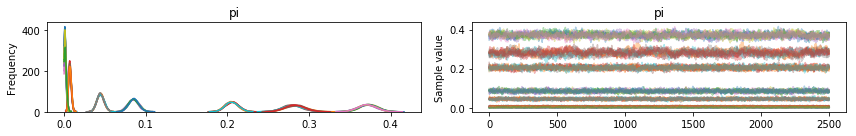

In [86]:
pm.traceplot( trace, varnames=['pi'] )

In [87]:
z = trace['z'][-1000:,:]

z_hat = np.zeros( I )
empirical_confidence
for i in range( I ):
    z_hat[ i ] = np.bincount( z[:,i] ).argmax()

In [116]:
z_hat[0]

1.0

In [88]:
np.set_printoptions(precision=2)
for j in range( J ):
    print( "Annotator j=" + str(j) )
    Cj = trace['goodness'][-1,j]
    print( Cj )

Annotator j=0
0.0640195193487163
Annotator j=1
1.6036611704709371
Annotator j=2
1.2566797230469469
Annotator j=3
5.495683323824877
Annotator j=4
4.9113858924274565
Annotator j=5
0.3575437082569143
Annotator j=6
3.0830613279491565
Annotator j=7
3.078278189369485
Annotator j=8
15.416506750264281
Annotator j=9
1.2658418276269736
Annotator j=10
4.302719158619946
Annotator j=11
1.8159133806230663
Annotator j=12
2.2487850595406895
Annotator j=13
4.452136515540915
Annotator j=14
1.3599175352157677
Annotator j=15
3.8527351420683895
Annotator j=16
4.2048514182346475
Annotator j=17
2.9195323545081906
Annotator j=18
1.896914746964292
Annotator j=19
2.118795649804467
Annotator j=20
0.2176105674937111
Annotator j=21
0.5207885757527074
Annotator j=22
0.4202406166561032
Annotator j=23
1.069159011540275
Annotator j=24
3.15663240406247
Annotator j=25
7.02914112550649
Annotator j=26
7.087972309813681
Annotator j=27
0.003142198613892206
Annotator j=28
1.0235247105327865
Annotator j=29
1.3360627043796993


In [89]:
z_hat

array([1., 3., 0., ..., 7., 7., 7.])

In [90]:
len(z_hat)

4232

/home/alex/anaconda3/envs/main/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


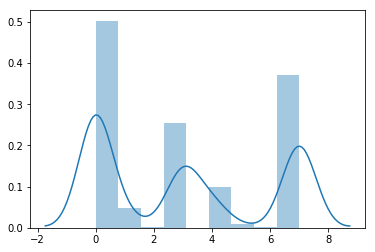

In [91]:
sns.distplot(z_hat)

In [96]:
I

4232

In [92]:
z_hat[0:10]

array([1., 3., 0., 0., 0., 0., 7., 0., 0., 1.])

In [93]:
df['Answer.id'].nunique()

4232

In [94]:
pd.DataFrame(z_hat).describe()

,0
count,4232.000000
mean,2.999764
std,2.898300
min,0.000000
25%,0.000000
50%,3.000000
75%,7.000000
max,7.000000


In [117]:
mappaii[10]

10

In [118]:
df[df['Answer.id']==mappaii[10]]['Answer.relation']

1187     4
4349     4
14582    7
16988    0
Name: Answer.relation, dtype: category
Categories (8, int64): [0, 1, 2, 3, 4, 5, 6, 7]

In [119]:
df.r[df.i[df.i==10].index]

1187     4
4349     4
14582    7
16988    0
Name: r, dtype: int8

In [120]:
z_hat[10]

0.0

In [ ]:
pm

In [120]:
alpha

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [121]:
pi

pi

In [122]:
theta

theta

In [123]:
testval[0]

1

In [124]:
z_hat[0]

0.0

In [125]:
df.r[df.r==7]

0        7
2        7
3        7
6        7
11       7
13       7
15       7
22       7
26       7
27       7
28       7
29       7
33       7
34       7
37       7
43       7
47       7
56       7
58       7
62       7
65       7
67       7
71       7
72       7
74       7
76       7
77       7
79       7
82       7
86       7
        ..
20684    7
20697    7
20698    7
20700    7
20725    7
20729    7
20748    7
20749    7
20761    7
20762    7
20781    7
20794    7
20801    7
20815    7
20823    7
20825    7
20829    7
20843    7
20855    7
20869    7
20871    7
20897    7
20929    7
20945    7
20951    7
20998    7
21006    7
21015    7
21016    7
21023    7
Name: r, Length: 3386, dtype: int8

In [122]:
trace.get_values('z',burn=)

array([[1, 3, 0, ..., 7, 7, 7],
       [1, 3, 0, ..., 7, 0, 7],
       [1, 3, 0, ..., 7, 0, 7],
       ...,
       [1, 3, 0, ..., 7, 0, 7],
       [1, 3, 0, ..., 7, 0, 7],
       [1, 3, 0, ..., 7, 0, 7]])

In [131]:
sd = pm.summary(trace,varnames='z')['sd'].values

In [123]:
pm.diagnostics.gelman_rubin(trace)

{'z': array([1., 1., 1., ..., 1., 1., 1.]),
 'goodness': array([1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.01,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.01, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.01, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 

In [132]:
z_hat

4232

In [147]:
final_answers = pd.DataFrame({'relation':z_hat.astype(int),'uncertainty':sd/np.max(sd)})
final_answers['id'] = final_answers.index.map(mappaii)

In [156]:
len(final_answers)

4232

In [164]:
final_answers[final_answers.uncertainty<0.5].sort_values(by='uncertainty') # but with 0.5 we look fine

,relation,uncertainty,id
378,0,0.000000,379
1443,0,0.000000,1451
228,3,0.000000,228
640,0,0.000000,644
231,0,0.000000,231
1509,0,0.000000,1518
1952,0,0.000000,1962
2482,3,0.000000,2494
1564,0,0.000000,1573
104,0,0.000000,104


In [167]:
df.r[df.i[df.i==1907].index] # but with 0.5 we look fine

2956     3
7729     4
7730     1
16669    0
18228    0
Name: r, dtype: int8

In [169]:
final_answers[final_answers.uncertainty<=0.5].groupby('relation').size()

relation
0    871
1    114
3    651
4    210
5     18
7    522
dtype: int64

In [170]:
len(final_answers[final_answers.uncertainty<=0.5])

2386

In [158]:
final_answers.groupby('relation').size()

relation
0    1655
1     156
2       4
3     837
4     327
5      28
6       3
7    1222
dtype: int64

In [172]:
toannotate = pd.read_csv('to_annotate.csv',index_col=0)

In [174]:
final_answers.set_index('id',inplace=True)

In [176]:
pd.concat([final_answers,toannotate],axis=1)

,relation,uncertainty,sentence
id,,,
0,1,0.266243,What do I wear to a fashion event to stand o...
1,3,0.042465,The designer who has spent several years in fa...
2,0,0.837206,On the invitation it says to dress to impress ...
3,0,0.167636,"For a day on campus , try a white and black ja..."
4,0,0.215334,Fall 2013 Style Inspiration : What To Wear To ...
5,0,0.063669,But before I jet off to South Beach to enjoy s...
6,7,0.280358,"It 's still 40 degrees in some places , after ..."
7,0,0.526135,The shoe has a touch of Miu Miu and regal clas...
8,0,0.762287,Who : Glamour girls will love this dramatic ...
